# Code to demonstrate electon density -> energy inversion as per Semeter & Kamalabadi 2005

written by Riley Troyer Fall 2021

In [1]:
# Libraries
from datetime import datetime as dt
import gc
import h5py
from matplotlib import pyplot as plt
from matplotlib import colors
import msise00
import numpy as np
import os
import pickle
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import savgol_coeffs
from scipy.integrate import trapezoid

# Disable divide by zero numpy warnings
np.seterr(divide='ignore')
np.seterr(invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## The first thing I do is read in a config file with various parameters that I could change from run to run.

In [2]:
# Read in config file with dictionary of specified inputs
import config_example as config
config_data = config.run_info['config_info']

# Path to pfisr data directory
pfisr_data_dir = config_data['isr_data_dir']

# Get location of PFISR
pfrr_lat = config_data['isr_lat']
pfrr_lon = config_data['isr_lon']

# Define test flux in m^-2 s^-1
F = config_data['test_flux']

# Don't use PFISR data below this altitude in km
pfisr_min_alt = config_data['isr_min_alt']

# Get sensitivity limit of PFISR
pfisr_sensitivity = config_data['isr_sensitivity']

# Parameters for smoothing PFISR data
pfisr_smooth_window = config_data['isr_smooth_window']
pfisr_smooth_poly_order = config_data['isr_smooth_poly_order']

# Altitude in meters to approximate infinity when calculating
#...mass distance
max_msis_alt = config_data['max_msis_alt']

# Maximum number of iterations to run maximum entropy process on
max_iterations = config_data['max_iterations']

# Reduced chi square to aim for
good_fit = config_data['reduced_chi_square']

# Define arrays for altitude and energy bins

# Altitude in meters
#...number of points should be around the same as pfisr data
altitude_bins = config_data['altitude_bins']

# Energies in eV
#...should probably be less than altitude bins to avoid overfitting
energy_bins = config_data['energy_bins']

# Get files to run code for
pfisr_files = config.run_info['run_files']

In [3]:
# For example code just use one file
pfisr_filename = pfisr_files[12]

## Next I read in a file containing information about the $\Lambda$ function as per Semeter & Kamalabadi 2005. More on this later. As well as the file containing the ISR data.

In [121]:
def get_isr_data(pfisr_filename, pfisr_data_dir):
    """Function to get relevant data from PFISR datafile.
    INPUT
    pfisr_filename
        type: str
        about: data file name, should be .h5 file
    pfisr_data_dir
        type: str
        about: directory where isr data is stored
    OUTPUT
    utc_time
        type: array of datetimes
        about: time stamp for each measurement
    pfisr_altitude
        type: array of float
        about: altitude stamp for each measurement in meters
    e_density
        type: array of float
        about: electron number density in m^-3
    de_density
        type: array of float
        about: error in number density
    """
    
    # Read in the h5 file
    pfisr_file = h5py.File(pfisr_data_dir + pfisr_filename, 'r')

    # Get the different beams and select specified angle
    beam_angle = 90
    beams = np.array(pfisr_file['BeamCodes'])

    # Get the beam with a 90 degree elevation angle
    indexes = np.linspace(0, len(beams)-1, len(beams))
    beam_num = int(indexes[np.abs(beams[:,2] - beam_angle) == 0][0])

    # Get time and convert to utc datetime
    unix_time = np.array(pfisr_file['Time']['UnixTime'])[:,0]
    utc_time = np.array([dt.utcfromtimestamp(d) for d in unix_time])

    # Get the altitude array
    pfisr_altitude = np.array(pfisr_file['NeFromPower']
                              ['Altitude'])[beam_num, :]

    # Get the uncorrected number density array
    e_density = np.array(pfisr_file['NeFromPower']
                         ['Ne_NoTr'])[:, beam_num, :]

    # Take the transpose
    e_density = np.transpose(e_density)
    
    # Smooth the electron density
    window = pfisr_smooth_window
    poly_order = pfisr_smooth_poly_order
    e_density = savgol_filter(e_density, window, poly_order,
                              axis=0)
    
    # Find the noise floor by averaging between 55km and 60km
    #...assume this should be zero
    noise_floor = np.mean(e_density[(pfisr_altitude > 55000)
                                    & (pfisr_altitude < 60000), :],
                          axis=0)
    
    # Loop through each column and subtract off noise floor
    for j in range(e_density.shape[1]):
        e_density[:, j] = e_density[:, j] - noise_floor[j]
    
    # Get error values
    de_density = np.array(pfisr_file['NeFromPower']
                          ['errNe_NoTr'])[:, beam_num, :]
    de_density = np.transpose(de_density)
    
    # Trying to figure out how to adjust errors based on smoothing
    adjustment = np.sqrt((3 * (3 * window**2 - 7))
                         /(4 * window * (window**2 - 4)))
    
    de_density = de_density * adjustment

    # Close file
    pfisr_file.close()
    
    return utc_time, pfisr_altitude, e_density, de_density

In [122]:
# Read in file with energy dissipation function
lambda_filename = 'semeter_kamalabadi_lambda_function.txt'
lambda_data = np.loadtxt(lambda_filename, skiprows=5)

# Create an interpolated function from this
#...values outside set to 0
lambda_interp = interp1d(lambda_data[:, 0], lambda_data[:, 1],
                         bounds_error=False, fill_value=0)

In [123]:
# Read in the pfisr data
(utc_time, pfisr_altitude,
 e_density, de_density) = get_isr_data(pfisr_filename, pfisr_data_dir)

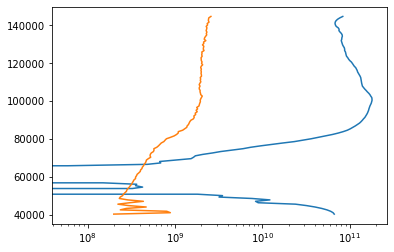

In [124]:
plt.plot(e_density[:, 150], pfisr_altitude)
plt.plot(de_density[:, 150], pfisr_altitude)
plt.xscale('log')

## For example purposes I'll only consider one time slice of the data. These calculations require information about the atmospheric density at the given time and location. To determine this I will run the MSISE00 model.

In [125]:
def get_msis_density(run_time, altitudes_z, max_alt=1001e3,
                     glat=65.117, glon=212.540):
    """Function to get MSIS calculated atmospheric densities.
    DEPENDENCIES
        msise00, numpy, scipy.interpolate.interp1d
    INPUT
    run_time
        type: datetime
        about: time to run msis code for
    altitudes
        type: array of floats
        about: altitudes in meters to run msis code for
    max_alt = 1001e3
        type: float
        about: maximum altitude in meters to run msis for. 
               Function creates a high altitude log spaced array
               between the max of altitudes and the max_alt value.
               This is primarily for approximating an indefinite integral.
    OUTPUT
    total_msis_alt
        type: array of floats
        about: altitudes values in meters including original array and
               high altitude array
    msis_interp_density
        type: scipy.interplate function
        about: 1d interpolation of msis density spanning entire altitude
               range.
    """
    
    # Run msis for lower altitudes
    msis_run_low = msise00.run(time=run_time, altkm=altitudes_z/1000,
                               glat=pfrr_lat, glon=pfrr_lon)

    # Define a higher altitude array
    msis_alt_high = np.logspace(np.log10(max(altitudes_z)+1),
                                np.log10(max_alt), 20)
    
    # Run msis for these higher altitudes
    msis_run_high = msise00.run(time=run_time, altkm=msis_alt_high/1000,
                               glat=pfrr_lat, glon=pfrr_lon)

    # Get total density data
    msis_density_low = msis_run_low['Total'].data[0, :, 0, 0]
    msis_density_high = msis_run_high['Total'].data[0, :, 0, 0]

    # Combine altitude and densities from low and high altitudes
    total_msis_alt = np.concatenate((altitudes_z, msis_alt_high))
    total_msis_density = np.concatenate((msis_density_low,
                                         msis_density_high))

    # Create a scipy interpolation function to define density v. altitude
    msis_interp_density = interp1d(total_msis_alt, total_msis_density)
    
    return total_msis_alt, msis_interp_density

In [162]:
# Time slice to run inversion for
slice_n = 93

# Time associated with slice
run_time = utc_time[slice_n]

# Get MSIS calculated densities
(total_msis_alt,
 msis_interp_density) = get_msis_density(run_time, altitude_bins,
                                         max_alt=max_msis_alt,
                                         glat=pfrr_lat, glon=pfrr_lon)

# Get density for altitude bins
total_msis_density = msis_interp_density(total_msis_alt)
density_rho = msis_interp_density(altitude_bins)

## Calculate the mass distance of a particle travelling through the atmosphere. This is defined as 
## $s(z) = \frac{1}{\cos(I)}\int_{z_0}^\infty \, \rho(z)\, dz$
### where $I=0$ is the incident angle of the particles and $\rho(z)$ is the MSISE00 calculated mass density. 
### To approximate $\infty$ I integrate out to 1000 km. I do the integration using the trapezoid method, which seems to be plenty good enough.

In [163]:
def mass_distance(z_i, I=0):
    """Function to mass distance of particle traveling some distance
    into the atmosphere. Denoted s in the derivations.
    Using trapezoid rule for this, which seems to be good enough
    INPUT
    z
        type: int
        about: index of altitude that particle reached to
    I=0
        type: float
        about: angle of magnetic inclination at measuring site in radians
    OUTPUT
    s
        type: float
        about: mass distance in kg m^-2
    """
    
    # Calculate mass distance traveled 
    s = (1/np.cos(I)) * trapezoid(total_msis_density[z_i:],
                                  total_msis_alt[z_i:])
    
    return s

In [164]:
# Calculate mass distance (s) for each altitude by integrating
#...out to 1000 km (~infinity)
s = np.array([mass_distance(z) for z in range(len(altitude_bins))])

## The mass distance is needed to calculate the ion production rate. The ion production rate is important since 
## $q(z) = A(z, K) \phi(K)$
### where $z$ is altitude and $K$ is energy. So if we know $q(z)$ we can invert A and get the number flux $\phi(K)$ in the specified energy bins.

## As derived in the paper
## $q(z, K) = \frac{\Lambda(s/R) \rho(z) K F}{35.5 R(K)} $
### where $\Lambda$ is a discrete function defined in a table in the paper, $F$ is a test number flux, and $R$ is a range-energy function.

In [165]:
def barrett_hays_range_energy_func(K):
    """Function to define mass range of electron in air for a specific
    energy K in eV. From Barett & Hays 1976
    INPUT
    K
        type: float
        about: energy of electron in eV
    OUTPUT
    R
        type: float
        about: mass range of particle in kg m^-2 
    """
    # Convert energy to keV to match formula
    K = K/1000
    
    # Range function
    R = 4.3e-7 + 5.36e-6 * K**(1.67) - 0.38e-8 * K**(-0.7)
    
    # Convert R from g/cm^2 to kg/m^2
    R = R * 10
    
    return R

In [166]:
# Calculate ion production rate for each energy and store
#...in dictionary
ion_prod_rate = {}

for i, energy in enumerate(energy_bins):

    # Calculate range-energy value
    R = barrett_hays_range_energy_func(energy)

    # Get the (s/R)(z) for the energy
    s_R = s/R

    # Use s/R to get Lambda function values
    lambda_vals = lambda_interp(s_R)

    # Use all of this to calculate ion production rate as function
    #...of alt
    q = (lambda_vals * density_rho * energy * F) / (35.5 * R)

    # Write to dictionary
    ion_prod_rate[energy] = q

## Calculate the matrix $A$. Each column of this corresponds to an energy bin and is equal to the ion production rate multiplied by the energy bin width and divided by the test flux.

In [167]:
# Construct the A matrix
matrix_A = np.zeros([len(altitude_bins), len(energy_bins)])

# Loop through each energy value
for j in range(len(energy_bins)):

    # Get the size of the energy bin
    #...first bin is from zero to energy
    if j == 0:
        delta_E = energy_bins[j] - 0
    else:
        delta_E = energy_bins[j] - energy_bins[j-1]

    # Set column of matrix
    matrix_A[:, j] = ion_prod_rate[energy_bins[j]] * (delta_E/F)

## To guide the inversion process we will use the ion production rate as seen by the ISR. This is defined as
## $q(z) = \alpha n(z)^2 + \frac{dn}{dt}$
### where $n(z)$ is the ISR measured electron density. We assume $\frac{dn}{dt} = 0$. We believe this is a good assumption during pulsating aurora, where the electron density doesn't change much.
### $\alpha$ is the recombination coefficient. At some point we may include ISR temperatures to calculate this, but for the moment we just use
### $\alpha(z) = 2.5 \times 10^{-12}\, e^{-z/51.2}$ 

In [168]:
def recombination_coeff(z):
    """Function defining recombination coefficient
    INPUT
    z
        type:float
        about: altitude in kilometers
    OUTPUT
    alpha
        type: float
        about: recombination coefficient in m^3/s
    """
    
    alpha = 2.5e-12 * np.exp(-z/51.2)
    
    return alpha

def isr_ion_production_rate(slice_n):
    """Function to estimate the ion production rate from isr measurements
    INPUT
    slice_n
        type: integer
        about: data slice of isr data to take
    OUTPUT
    q_estimate
        type: array of float
        about: estimated ion production rate m^-2 s^-1
    dq_estimate
        type: array of float
        about: error in ion production rate
    alphas
        type: array of float
        about: recombination coefficients
    """
    
    # Read in density and errors in those measurements for specific time
    e_density_slice = e_density[:, slice_n]
    de_density_slice = de_density[:, slice_n]

    # Make an interpolation model of this data with respect to altitude
    #...but only do this for altitudes > defined minimum value,
    #...below this data can be weird
    pfisr_density_interp = interp1d(pfisr_altitude, e_density_slice)

    # Same interpolation except for error in density
    pfisr_error_interp = interp1d(pfisr_altitude, de_density_slice)

    # Calculate all recombination coeffcients
    alphas = np.array([recombination_coeff(z/1000) for z 
                       in altitude_bins])

    # Multiply by pfisr density to get an estimate of ion production rate
    q_estimate = alphas * pfisr_density_interp(altitude_bins)**2

    # Get error dq = 2*alpha*n*dn
    dq_estimate = (2 * alphas * pfisr_density_interp(altitude_bins)
                   * pfisr_error_interp(altitude_bins))
    
#     # Value below specified height km, assume are zero below data can be off
#     q_estimate[altitude_bins < pfisr_min_alt] = 0
    
#     # Also anywhere where error is larger than value set to zero
#     q_estimate[q_estimate <= dq_estimate] = 0
    
    return q_estimate, dq_estimate, alphas

In [169]:
# Get estimated ion production rate and error from isr measurements
q_estimate, dq_estimate, alphas = isr_ion_production_rate(slice_n)

## Before performing the maximum entropy iterations we need to define an initial number flux

In [170]:
def estimate_initial_number_flux(energy_bins, matrix_A):
    """Function to estimate the intial number flux for each energy bin
    INPUT
    energy_bins
        type: array of float
        about: energy values defining energy bins
    matrix_A
        type: array of float
        about: inversion matrix
    OUTPUT
    initial_num_flux
        type: array of float
        about: estimated number flux in m^-2 s^-1 for each energy bin
    """
    
    # Make an initial guess of the number flux
    initial_num_flux = np.ones(len(energy_bins))*(1e12/len(energy_bins))

    # Divide by energy bin widths
    bin_widths = energy_bins - np.roll(energy_bins, shift=1)

    # Fix first value
    bin_widths[0] = energy_bins[0] - 0

    # Set initial guess
    initial_num_flux = initial_num_flux/bin_widths

    # If full column of A matrix is zero set initial flux to zero
    for j in range(len(energy_bins)):

        if np.sum(matrix_A[:, j]) == 0:
            initial_num_flux[j] = 0
            
    return initial_num_flux

In [171]:
# Make an initial guess of the number flux
initial_num_flux = estimate_initial_number_flux(energy_bins, matrix_A)

In [172]:
#initial_num_flux = np.ones(len(initial_num_flux))*1e8

## Perform the maximum entropy iterations to get an estimated number flux for each energy bin. I run the iterations until $\chi^2_\text{reduced} < 1.5$ between the $q(z)_\text{ISR} = \alpha(z) n(z)^2$ and $q(z)_\text{A} = A(z, K) \phi(K)$ or 1000 iterations are reached.

In [173]:
def maximum_entropy_iteration(initial_num_flux, altitude_bins, energy_bins,
                               matrix_A, q_estimate, dq_estimate):
    """Function to peform the maximum entropy iterative process to approximate
    inversion of matrix A. Process is outlined in Semeter & Kamalabadi 2005.
    INPUT
    initial_num_flux
        type: array of float
        about: initial guess of number flux for each energy bin in m^-2 s^-1
    altitude_bins
        type: array of float
        about: altitude values in meters defining altitude bins
    energy_bins
        type: array of float
        about: energy values in eV defining energy bins
    matrix_A
        type: array of float
        about: matrix that iteration is trying to invert
    q_estimate
        type: array of float
        about: estimated ion production rate from ISR m^-2 s^-1
    dq_estimate
        type: array of float
        about: error in ion production rate of ISR
    OUTPUT
    new_num_flux
        type: array of float
        about: estimated number flux for energy bins in m^-2 s^-1
    reduced_chi_square
        type: float
        about: error in modeled fit
    good_alt_index
        type: int
        about: lower than this won't be good data
    """
    
    # Set previous value to initial at start
    old_num_flux = initial_num_flux
    new_num_flux = np.zeros(len(initial_num_flux))  
    
    # Create array to store all minimum j values
    min_js = np.zeros(len(altitude_bins), dtype=int)

    # Find all nonzero indices of A matrix
    nonzero_args = np.argwhere(matrix_A > 0)

    for i in range(len(min_js)):

        non_zeros = nonzero_args[nonzero_args[:, 0] == i]

        # If there are no non zero values in row, then set to 
        #...first instance
        if len(non_zeros) == 0:
            min_js[i] = 0

        # Otherwise find the minimum j
        else:
            min_js[i] = min(non_zeros[:, 1])

    # Find the index past which A is defined for altitudes
    good_alt_index = np.argwhere(min_js>0)[0][0]

    # Run interations until chi2 < 1.5
    reduced_chi_square = 10

    # Or count < specified amount
    count = 0

    while ((reduced_chi_square > good_fit) 
           or (reduced_chi_square < (2 - good_fit))):    

        # Check count
        if count > max_iterations:
            print('Slice: {slice_n}. '
                  'Unable to converge. '
                  'Max iterations reached with chi2 = {chi2}'
                  .format(slice_n=slice_n,
                          chi2=round(reduced_chi_square, 2)))
            break

        # Construct the t vector
        t = 1/np.dot(matrix_A[:, min_js], old_num_flux[min_js])

        # Adjust for infinite values in regions without a nonzero j
        t[t == np.inf] = 0        

        for j in range(len(energy_bins)):

            # Construct c vector
            frac = np.inner(matrix_A, old_num_flux)/q_estimate
            c = 20 * (1 - frac) * t

            # Account for nan and infinite values
            #...this is why warning is raised
            c[np.isnan(c)] = 0
            c[c == -np.inf] = 0
            c[c == np.inf] = 0

            # Define w constant
            w = np.ones(len(altitude_bins))/len(altitude_bins)

            # Summation of matrix elements
            i_sum = np.sum(w*c*matrix_A[:, j])

            # New guess
            new_num_flux[j] = old_num_flux[j]/(1-old_num_flux[j]*i_sum)

        # Check chi squared, but only on altitudes that A is defined for
        diff=q_estimate-np.dot(matrix_A, new_num_flux)
        chi_square_array = diff**2/dq_estimate**2

        # Set undefined values to zero
        chi_square_array[np.isnan(chi_square_array)] = 0
        chi_square_array[chi_square_array == np.inf] = 0
        chi_square_array[chi_square_array == -np.inf] = 0

        # Get the chi squared value
        chi_square = np.sum(chi_square_array)

        # And the reduced chi square, which should be around 1
        reduced_chi_square = chi_square/(len(diff)-1)

        # Set old value to new
        old_num_flux = np.copy(new_num_flux)

        # Set count
        count = count + 1

    if count < max_iterations:
        print('Slice: {slice_n}. '
              'Convergence reached. '
              'Iterations: {count}'.format(slice_n=slice_n,
                                           count=count-1))
        
    return new_num_flux, reduced_chi_square, good_alt_index

In [174]:
# Perform the maximum entropy iterative process
(new_num_flux,
 reduced_chi_square,
 good_alt_index) = maximum_entropy_iteration(initial_num_flux,
                                             altitude_bins, energy_bins,
                                             matrix_A,
                                             q_estimate, dq_estimate)

Slice: 93. Unable to converge. Max iterations reached with chi2 = 0.26


In [175]:
# Store results in dictionary
inversion_results = {}

# Write data to dictionary
d = {'altitude' : altitude_bins,
     'initial_density' : np.sqrt(np.dot(matrix_A,
                                        initial_num_flux)/alphas),
     'modeled_density' : np.sqrt(np.dot(matrix_A,
                                        new_num_flux)/alphas),
     'measured_density' : np.sqrt(q_estimate/alphas),
     'energy_bins' : energy_bins,
     'modeled_flux' : new_num_flux,
     'reduced_chi2' : reduced_chi_square,
     'units' : 'Values given in meters, seconds, electron-volts.'
    }

inversion_results[run_time] = d

## Plot the ISR number density and modeled number density to see how well fit worked. Also plot energy spectrum.

In [176]:
def inversion_density_plot(inversion_results, run_time):
    """Function to create and save a plot of the inversion 
    electron density.
    INPUT
    inversion_results
        type: dictionary
        about: dictionary of inversion results
    run_time
        type: datetime
        about: time to create plot for
    OUTPUT
    none
    """
    # Get altitude values
    altitudes_z = inversion_results[run_time]['altitude']

    # Get measured density
    pfisr_density_plot = inversion_results[run_time]['measured_density']
    pfisr_density_plot = pfisr_density_plot

    # Initial guess
    initial_guess_plot = inversion_results[run_time]['initial_density']
    initial_guess_plot = initial_guess_plot
    
    # Finally modeled guess
    final_guess_plot = inversion_results[run_time]['modeled_density']
    final_guess_plot = final_guess_plot
    
    # Get chi2
    reduced_chi2 = inversion_results[run_time]['reduced_chi2']

    # Plot figure of initial guess, real data and fit
    fig, ax = plt.subplots()

    # Titles and axis labels
    ax.set_title(str(run_time) + r' $\chi^2=$' 
                 + str(round(reduced_chi2, 2)),
                 fontsize=14, fontweight='bold')

    ax.set_ylabel('Altitude [km]', fontsize=14)
    ax.set_xlabel(r'Electron Density [m$^{-3}$]', fontsize=14)

    # Axis
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)

    ax.set_xscale('log')

    # Plot PFISR data
    ax.plot(pfisr_density_plot, altitudes_z/1000,
            color='k', linewidth=2, label = 'PFISR')

    # Plot initial guess
    ax.plot(initial_guess_plot, altitudes_z/1000,
            color='C2', linewidth=2, label = 'Initial Guess')

    # Plot final guess
    ax.plot(final_guess_plot, altitudes_z/1000,
            color='C1', linewidth=2, label = 'Final Guess')
    
    ax.plot(np.sqrt(dq_estimate/alphas), altitudes_z/1000, color='red')

    plt.legend()

    plt.tight_layout()

def inversion_numflux_plot(inversion_results, run_time):
    """Function to create and save a plot of the inversion 
    energy spectrum.
    INPUT
    inversion_results
        type: dictionary
        about: dictionary of inversion results
    run_time
        type: datetime
        about: time to create plot for
    OUTPUT
    none
    """
    # Get energy values
    energies_K = inversion_results[run_time]['energy_bins']
    
    # Get modeled number flux values
    num_flux = inversion_results[run_time]['modeled_flux']
    
    # Get differential number flux by multiplying by energy bin width
    bin_widths = energies_K - np.roll(energies_K, shift=1)
    
    # Fix first value
    bin_widths[0] = energies_K[0] - 0
    
    num_flux = num_flux*bin_widths
    
    # Get chi2
    reduced_chi2 = inversion_results[run_time]['reduced_chi2']

    # Plot figure of energy spectrum
    fig, ax = plt.subplots()

    # Titles and axis labels
    ax.set_title(str(run_time) + r' $\chi^2=$' 
                 + str(round(reduced_chi2, 2)),
                 fontsize=14, fontweight='bold')

    ax.set_ylabel(r'Number Flux [m$^{-2}$ s$^{-1}$ eV$^{-1}$]',
                  fontsize=14)
    ax.set_xlabel('Energy [eV]', fontsize=14)

    # Axis
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)

    ax.set_xscale('log')
    ax.set_yscale('log')

    # Plot the energy
    ax.plot(energies_K, num_flux)

    plt.tight_layout()

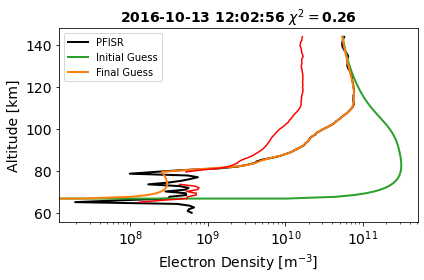

In [177]:
# Plot density
inversion_density_plot(inversion_results, run_time)

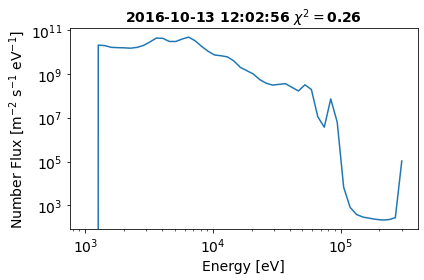

In [178]:
# Plot energy spectrum
inversion_numflux_plot(inversion_results, run_time)